In [1]:
!pwd

/home/evanlee/PBMC_Hao/Level_1_type


In [2]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import scanpy as sc
import sklearn
from scipy.sparse import csr_matrix
from sklearn.metrics.cluster import adjusted_rand_score
import copy

# os.chdir('/Users/evanli/Documents/Research_datasets/PBMC_Hao')
adata_raw = sc.read('/home/evanlee/PBMC_Hao/Hao_PBMC.h5ad')
print(adata_raw.shape)  # row is cells, column is gene
# (161764, 20568)

(161764, 20568)


In [3]:
# 先不轉 CPM
# Total-count normalize the data matrix X to 10,000 reads per cell
# sc.pp.normalize_total(adata, target_sum=1e4)

# Log
sc.pp.log1p(adata_raw)

## UMAP

In [4]:
# Delete the 'neighbors' key from adata.uns
# if 'neighbors' already exists in adata.uns, error would occurs at sc.pp.neighbors
if 'neighbors' in adata_raw.uns:
    del adata_raw.uns['neighbors']

In [5]:
# PCA
sc.tl.pca(adata_raw, svd_solver='arpack')

# Neighborhood graph
sc.pp.neighbors(adata_raw, n_neighbors=15, n_pcs=40)

/home/evanlee/.local/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/evanlee/.local/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/evanlee/.local/lib/python3.8/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: Th

In [21]:
# create color palette for cell types
import seaborn as sns

palette = sns.color_palette('tab10', n_colors=len(types)+1)
del palette[7]
palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)]

/home/evanlee/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


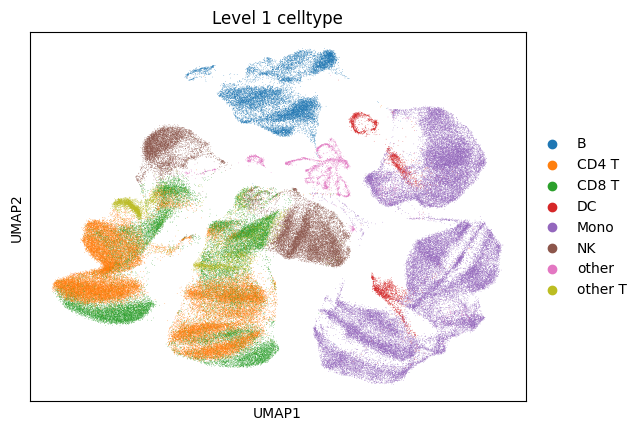

In [24]:
# UMAP

sc.tl.umap(adata_raw)
# sc.pl.umap(adata)
sc.pl.umap(adata_raw, color='celltype.l1', title='Level 1 celltype', palette=palette)

In [7]:
# Leiden clustering
sc.tl.leiden(adata_raw)

/home/evanlee/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


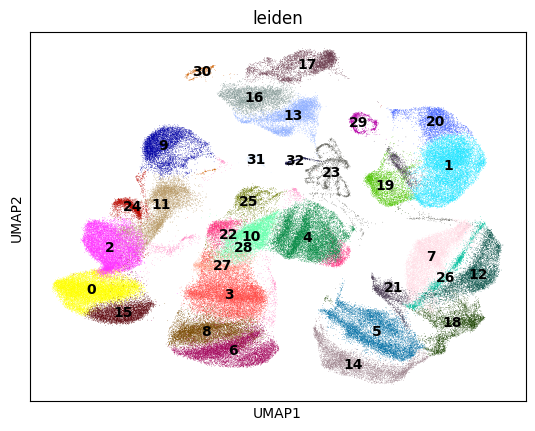

In [8]:
# Plot Leiden
sc.pl.umap(adata_raw, color='leiden', legend_loc="on data")

## Representative cells
Select top 20% clustering coefficient cells in each cell type

In [9]:
umap_adja_matrix = adata_raw.obsp['connectivities']
umap_adja_matrix

<161764x161764 sparse matrix of type '<class 'numpy.float32'>'
	with 3473806 stored elements in Compressed Sparse Row format>

In [10]:
# Clustering coefficient
import networkx as nx

G = nx.from_scipy_sparse_array(umap_adja_matrix)
print(G)

clustering_coeff = nx.clustering(G)
print(len(clustering_coeff))

Graph with 161764 nodes and 1736903 edges
161764


In [11]:
adata_raw.obs.columns

Index(['nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA',
       'orig.ident', 'lane', 'donor_id', 'time', 'celltype.l1', 'celltype.l2',
       'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT',
       'cell_type_ontology_term_id', 'sex_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id',
       'development_stage_ontology_term_id', 'disease_ontology_term_id',
       'assay_ontology_term_id', 'is_primary_data',
       'organism_ontology_term_id', 'tissue_ontology_term_id',
       'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex',
       'tissue', 'self_reported_ethnicity', 'development_stage', 'leiden'],
      dtype='object')

In [12]:
# All level 1 celltypes
types = np.unique(adata_raw.obs['celltype.l1']).tolist()
# cell count in each celltype
adata_raw.obs['celltype.l1'].value_counts()

celltype.l1
Mono       49010
CD4 T      41001
CD8 T      25469
NK         18664
B          13800
other T     6789
DC          3589
other       3442
Name: count, dtype: int64

In [13]:
# Select top 20% clustering coefficient cells in each cell type
alltype_selected = dict()

for celltype in types:
    # select cells from one celltype
    celltype_idx = np.where(adata_raw.obs['celltype.l1'] == celltype)[0]
    celltype_coeff = {node_idx: clustering_coeff[node_idx] for node_idx in celltype_idx}
    
    top20_count = int(len(celltype_coeff) * 0.2)
    top20_indices = sorted(celltype_coeff, key=celltype_coeff.get, reverse=True)[:top20_count]
    celltype_selected = {node_idx: celltype_coeff[node_idx] for node_idx in top20_indices}
    alltype_selected.update(celltype_selected)
    print(celltype, len(celltype_selected))

B 2760
CD4 T 8200
CD8 T 5093
DC 717
Mono 9802
NK 3732
other 688
other T 1357


In [14]:
len(alltype_selected)

32349

In [15]:
# add column to adata.obs
is_representative = ['Yes' if cell in alltype_selected.keys() else 'No' for cell in clustering_coeff.keys()]
is_representative = np.array(is_representative)

# Add is_representative (Yes or No) to data.obs
adata_raw.obs['is_representative'] = is_representative
# adata_raw.obs.head()

In [16]:
sum(adata_raw.obs['is_representative'] == 'Yes')

32349

In [17]:
# Add a column: Cluster_representative
# 在 representative cell 中，加上 cluster
clus_rep = []
for i in range(adata_raw.shape[0]):
    if adata_raw.obs['is_representative'][i] == 'Yes':
        # Yes_cluster_name
        clus_rep.append(adata_raw.obs['is_representative'][i] + '_' + adata_raw.obs['celltype.l1'][i])
    else:
        # No
        clus_rep.append(adata_raw.obs['is_representative'][i])

adata_raw.obs['cluster_representative'] = clus_rep

In [18]:
adata_raw.obs.head()

,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,orig.ident,lane,donor_id,time,celltype.l1,celltype.l2,...,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,leiden,is_representative,cluster_representative
L1_AAACCCAAGAAACTCA,7430.0,221,10823.0,2915,P2_7,L1,P2,7,Mono,CD14 Mono,...,10x 3' v3,normal,Homo sapiens,unknown,blood,unknown,unknown,1,No,No
L1_AAACCCAAGACATACA,5949.0,211,5864.0,1617,P1_7,L1,P1,7,CD4 T,CD4 TCM,...,10x 3' v3,normal,Homo sapiens,unknown,blood,unknown,unknown,2,No,No
L1_AAACCCACAACTGGTT,6547.0,217,5067.0,1381,P4_3,L1,P4,3,CD8 T,CD8 Naive,...,10x 3' v3,normal,Homo sapiens,unknown,blood,unknown,unknown,15,No,No
L1_AAACCCACACGTACTA,3508.0,207,4786.0,1890,P3_7,L1,P3,7,NK,NK,...,10x 3' v3,normal,Homo sapiens,unknown,blood,unknown,unknown,9,No,No
L1_AAACCCACAGCATACT,6318.0,219,6505.0,1621,P4_7,L1,P4,7,CD8 T,CD8 Naive,...,10x 3' v3,normal,Homo sapiens,unknown,blood,unknown,unknown,15,No,No


## Plot representative cell UMAP

/home/evanlee/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


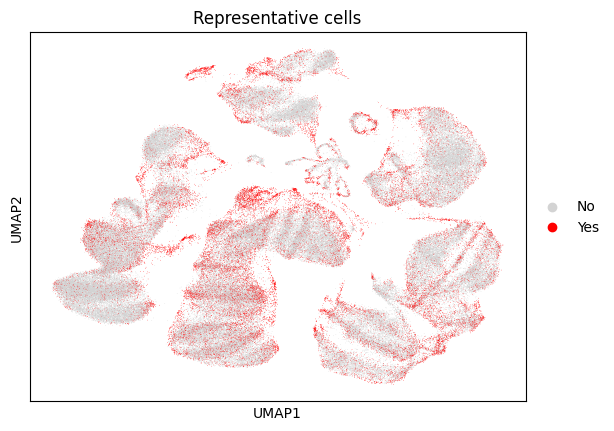

In [22]:
# Plot Yes/No representative cells
sc.pl.umap(adata_raw, color='is_representative', title='Representative cells', palette=['#D3D3D3', 'red'])

/home/evanlee/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


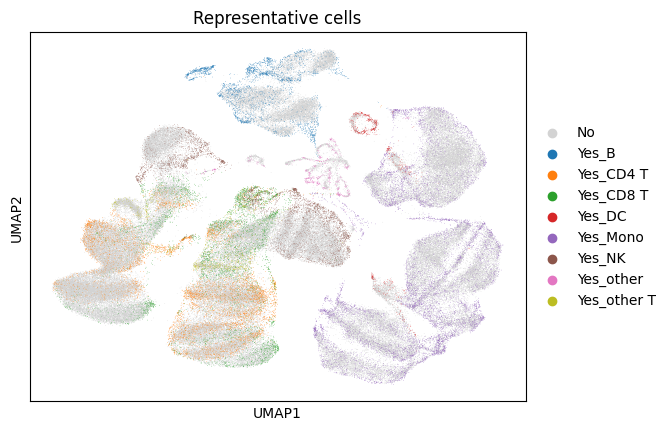

In [23]:
# Also differentiating representative cells from different cell types
sc.pl.umap(adata_raw, color='cluster_representative', title='Representative cells', palette=['#D3D3D3']+palette)

## Export representative cells adata

In [25]:
!pwd

/home/evanlee/PBMC_Hao/Level_1_type


In [26]:
adata_rep_cells = adata_raw[adata_raw.obs['is_representative'] == 'Yes']
adata_rep_cells.shape

(32349, 20568)

In [27]:
# adata_rep_cells.write_h5ad('Hao_PBMC_level1_rep_cells.h5ad')